# import

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from collections import defaultdict
import torch
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from keras import Model, backend
from keras.activations import relu, softmax
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, experimental, Lambda, Concatenate, Input, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.applications import ResNet50, ResNet152V2
from keras.optimizers import Adam
import tensorflow as tf

# Exploratory Data Analysis

Load in Dataset

In [2]:
data_dir = 'Dataset_BUSI_with_GT'
dataobjects=[]
Class=-1
Label=''
img_prop = defaultdict(list)

def generate_random_id():
    id_length = 8
    characters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    random_id = ''
    for _ in range(id_length):
        random_id += random.choice(characters)
    return random_id

# loop through images in all label subdirectories
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if label=='benign' or label== 'normal':
        Class=0
        Label='non-malignant'
    else:
        Class=1
        Label='malignant'      
    for image_file in os.listdir(label_dir):
        if not (image_file.endswith('_mask.png') or image_file.endswith('_mask_1.png') or image_file.endswith('_mask_2.png')):
            image = cv2.imread(os.path.join(label_dir, image_file))   
            dataobjects.append([image,Class,Label,os.path.join(label_dir, image_file)])

# shuffle the dataobjects for future training and testing
random.shuffle(dataobjects)
imgs=[dataobject[0] for dataobject in dataobjects]
classes=[dataobject[1] for dataobject in dataobjects]
labels=[dataobject[2] for dataobject in dataobjects]
img_paths=[dataobject[3] for dataobject in dataobjects]
img_prop['img_id']=[generate_random_id()for _ in range(len(imgs))]
img_prop['width']=[img.shape[0] for img in imgs]
img_prop['height']=[img.shape[1] for img in imgs]
img_prop['size']=[img.shape[0]* img.shape[1]*img.shape[2] for img in imgs]
img_prop['path']=img_paths
img_prop['img_aspect_ratio']=[img.shape[1]/img.shape[0] for img in imgs]
img_prop['label']=labels
img_prop['class']=classes
d = dict(selector="th",
    props=[('text-align', 'center')])

image_dataset = pd.DataFrame(img_prop).style.set_properties(**{'width':'10em', 'text-align':'center'})\
        .set_table_styles([d])
df=pd.DataFrame(img_prop).info()
image_dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   img_id            780 non-null    object 
 1   width             780 non-null    int64  
 2   height            780 non-null    int64  
 3   size              780 non-null    int64  
 4   path              780 non-null    object 
 5   img_aspect_ratio  780 non-null    float64
 6   label             780 non-null    object 
 7   class             780 non-null    int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 48.9+ KB


,img_id,width,height,size,path,img_aspect_ratio,label,class
0,QUIvFYE3,716,808,1735584,Dataset_BUSI_with_GT\benign\benign (106).png,1.128492,non-malignant,0
1,xcYbBwuH,468,625,877500,Dataset_BUSI_with_GT\malignant\malignant (128).png,1.335470,malignant,1
2,Q2hxo4Pv,470,547,771270,Dataset_BUSI_with_GT\normal\normal (71).png,1.163830,non-malignant,0
3,uQHlWLpB,573,765,1315035,Dataset_BUSI_with_GT\normal\normal (5).png,1.335079,non-malignant,0
4,fjIWxQKR,619,763,1416891,Dataset_BUSI_with_GT\normal\normal (38).png,1.232633,non-malignant,0
5,Auis1cY3,474,558,793476,Dataset_BUSI_with_GT\benign\benign (130).png,1.177215,non-malignant,0
6,kSkstRIm,574,772,1329384,Dataset_BUSI_with_GT\normal\normal (103).png,1.344948,non-malignant,0
7,0GzTlFcG,463,562,780618,Dataset_BUSI_with_GT\benign\benign (366).png,1.213823,non-malignant,0
8,Hsvjg7hg,485,733,1066515,Dataset_BUSI_with_GT\malignant\malignant (85).png,1.511340,malignant,1
9,HfCE21Iq,705,812,1717380,Dataset_BUSI_with_GT\normal\normal (36).png,1.151773,non-malignant,0


discuss result:we totally have 780 images with two classes including malignant and non-malignant. Also we show the properties with dataframes which indicates each image has different image size. The Aspect ratio is height/width. ImgId is generated randomly.

Class Image Examples

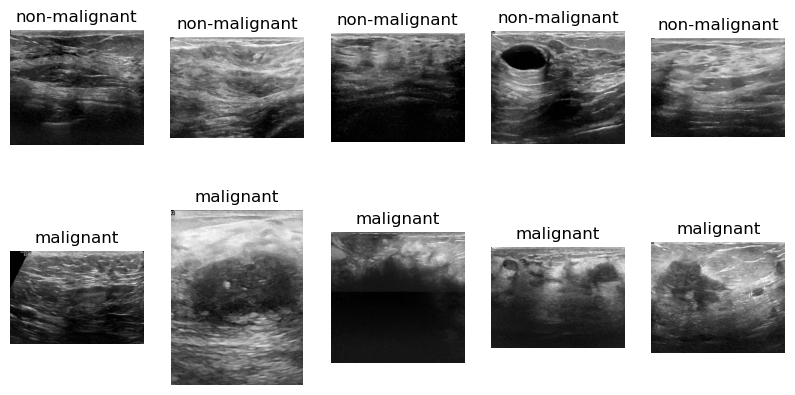

In [3]:
# filter list by label value
non_malignant_imgs=[dataobject[0] for dataobject in dataobjects if dataobject[1]==0]
malignant_imgs=[dataobject[0] for dataobject in dataobjects if dataobject[1]==1]

plt.figure(figsize=(10,5))
for i in range(1,11):
    if i <=5:
        plt.subplot(2,5,i) 
        plt.imshow(non_malignant_imgs[i]) 
        plt.title('non-malignant')
        plt.axis('off')
    else:
        plt.subplot(2,5,i) 
        plt.imshow(malignant_imgs[i]) 
        plt.title('malignant')
        plt.axis('off')

discuss result:this is the presentation of some of images from datasets. Each label shows five imagese

Class Imbalance Indication

Text(0.5, 1.0, 'Distribution of Labels within dataset')

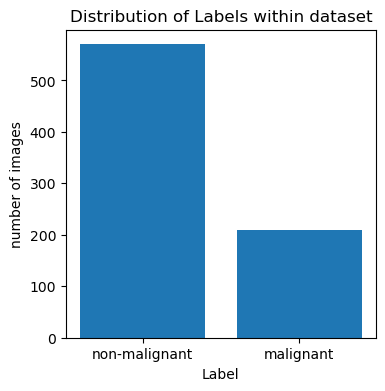

In [4]:
plt.figure(figsize=(4,4))
labels=np.array(['non-malignant','malignant'])
labels_counts=np.array([len(non_malignant_imgs),len(malignant_imgs)])
plt.bar(labels, labels_counts)
plt.xlabel("Label")
plt.ylabel("number of images")
plt.title("Distribution of Labels within dataset")

discuss result:From the above histogram,we can conclude that the number of the non-malignant is much larger than malignant.Hence,the class imbalance occurrs here

Average Pixel Intensities

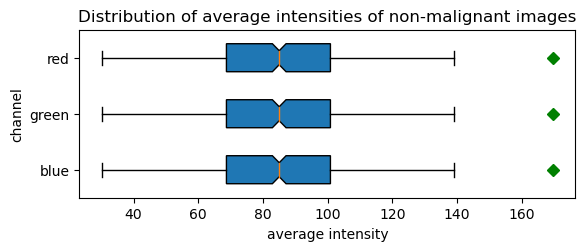

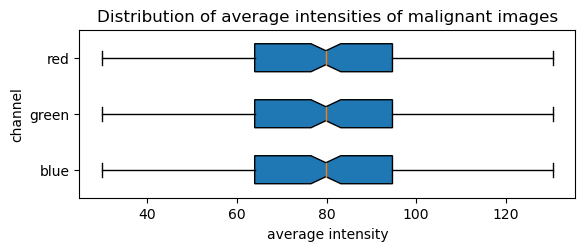

In [5]:
non_malignant_blue_averages=[np.mean((cv2.split(img)[0].reshape(-1))) for img in non_malignant_imgs]
non_malignant_green_averages=[np.mean((cv2.split(img)[1].reshape(-1))) for img in non_malignant_imgs]
non_malignant_red_averages=[np.mean((cv2.split(img)[2].reshape(-1)))for img in non_malignant_imgs]
malignant_blue_averages=[np.mean((cv2.split(img)[0].reshape(-1))) for img in malignant_imgs]
malignant_green_averages=[np.mean((cv2.split(img)[1].reshape(-1))) for img in malignant_imgs]
malignant_red_averages=[np.mean((cv2.split(img)[2].reshape(-1))) for img in malignant_imgs]
data1=[non_malignant_blue_averages,non_malignant_green_averages,non_malignant_red_averages]
data2=[malignant_blue_averages,malignant_green_averages,malignant_red_averages]

plt.subplot(2,1,1)
plt.boxplot(data1, labels=['blue','green','red'], notch=True, sym='gD', vert=False, widths=0.5, patch_artist=True)
plt.xlabel("average intensity")
plt.ylabel("channel")
plt.title("Distribution of average intensities of non-malignant images")
plt.show()

plt.subplot(2,1,2)
plt.boxplot(data2, labels=['blue','green','red'], notch=True, sym='gD', vert=False, widths=0.5, patch_artist=True)
plt.xlabel("average intensity")
plt.ylabel("channel")
plt.title("Distribution of average intensities of malignant images")
plt.show()

discuss result:For each class,each channel has the same distribution of average intensities of images. The non-malignant images commonly have higher average intensities than malignant. The average intensity mentioned here is the average intensity of single image 

Average Image Aspect Ratio per Class

Text(0.5, 1.0, 'Average image aspect ratio per class')

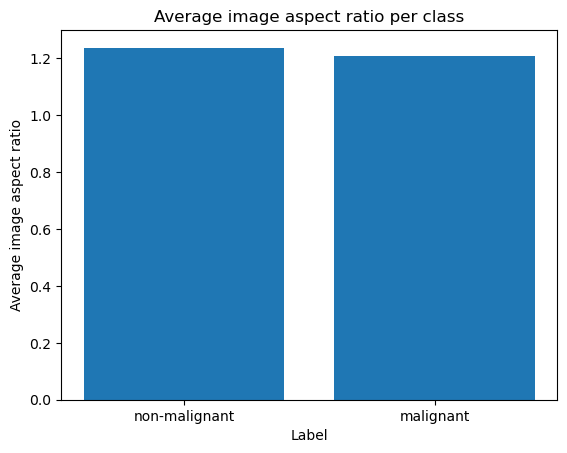

In [6]:
non_malignant_average=sum([img.shape[1]/img.shape[0] for img in non_malignant_imgs])/len(non_malignant_imgs)                                        
malignant_average=sum([img.shape[1]/img.shape[0] for img in malignant_imgs])/len(malignant_imgs)
plt.bar(labels, [non_malignant_average,malignant_average])
plt.xlabel("Label")
plt.ylabel("Average image aspect ratio")
plt.title("Average image aspect ratio per class")

discuss result: The non-malignant is only a bit higher than malignant. The average image aspect ratio is the overall average of all images per class.

Average Image Size per Class

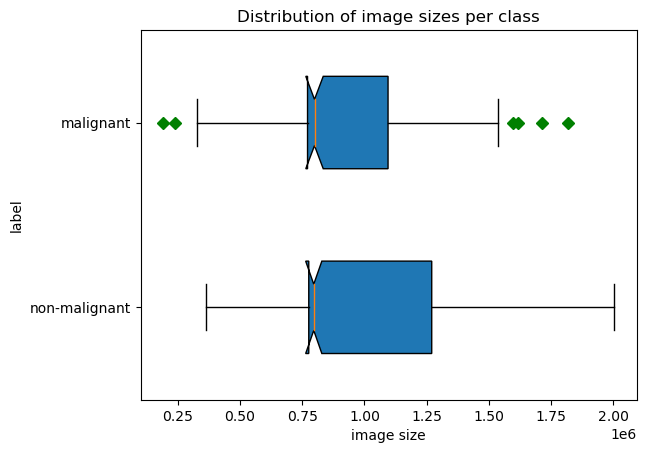

In [7]:
non_malignant_size_averages=[img.reshape(-1).shape[0] for img in non_malignant_imgs]
malignant_size_averages=[img.reshape(-1).shape[0] for img in malignant_imgs]

plt.boxplot([non_malignant_size_averages,malignant_size_averages], labels=['non-malignant','malignant'], notch=True,sym='gD',vert=False, widths=0.5, patch_artist=True)
plt.xlabel("image size")
plt.ylabel("label")
plt.title("Distribution of image sizes per class")
plt.show()

discuss results:For image size, some of the non-malignant is much larger than malignant. We use boxplot here because the image sizes vary significantly. The image size is width*height*3.

Average Intensity Amount per Class

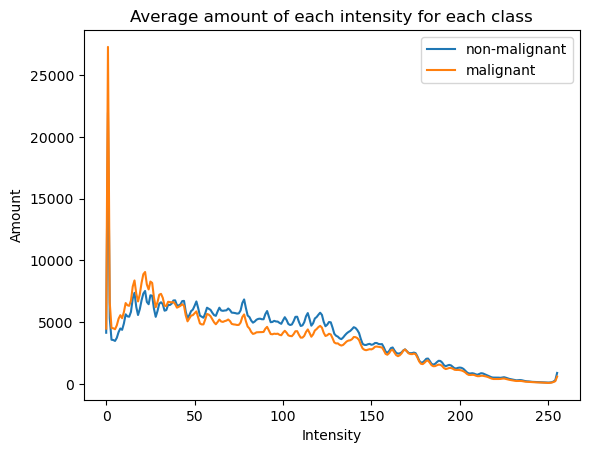

In [8]:
def average(i,imgs):
    count=0
    for img in imgs:
        count+=np.sum(img==i)
    return count/len(imgs)
n_m_average=[average(i,non_malignant_imgs) for i in range(256)]
m_average=[average(i,malignant_imgs) for i in range(256)]
plt.title("Average amount of each intensity for each class")
plt.plot(np.arange(256),n_m_average,label='non-malignant')
plt.plot(np.arange(256),m_average,label='malignant')          
plt.xlabel("Intensity")
plt.ylabel("Amount")
plt.legend()

discuss results:For average amount of intensities between 0 and 50,malignant is commonly higher than non-malignant.For average amount of intensities after 50,non-malignant is commonly higher than malignant. The average amount of each intensity mentioned here is the average amount of certain intensities from all images per class

Data PreProcessing - Extraction of train/test and normalisation

In [9]:
# For other models
imgs=np.array([cv2.resize(img,(150,150)).reshape(-1) for img in imgs])

# For VGG16 Model
#imgs=np.array([cv2.resize(img,(224,224)).reshape(-1) for img in imgs])
# normalize images
normalized_images = (imgs - np.min(imgs)) / (np.max(imgs) - np.min(imgs))
# split dataset into train set and test set
targets=[dataobject[1] for dataobject in dataobjects]
x_train,x_test,y_train,y_test=train_test_split(normalized_images,targets,test_size=0.3,random_state=10)
print(f'The number of training samples is {len(x_train)}')
print(f'The number of testing samples is {len(x_test)}')

The number of training samples is 546
The number of testing samples is 234


Transform training and testing data into Tensors

In [10]:
x_train_tensor = tf.concat(x_train, axis = 0)
y_train_tensor = tf.stack(y_train, axis = 0)
x_test_tensor = tf.concat(x_test, axis = 0)
y_test_tensor = tf.stack(y_test, axis = 0)

Reshaping train/test Image Tensors

In [11]:
# For other models
x_train_reshaped = tf.reshape(x_train_tensor, [546, 150, 150, 3])
x_test_reshaped = tf.reshape(x_test_tensor, [234, 150, 150, 3])

# For VGG16 Model
#x_train_vgg16 = tf.reshape(x_train_tensor, [546, 224, 224, 3])
#x_test_vgg16 = tf.reshape(x_test_tensor, [234, 224, 224, 3])

<h1>Models</h1>

<h4>VGG16</h4>

In [12]:
VGG16 = Sequential()

VGG16.add(experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train_reshaped.shape[1:]))
VGG16.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
VGG16.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(MaxPooling2D((2, 2),2))
VGG16.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(MaxPooling2D((2, 2),2))
VGG16.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(MaxPooling2D((2, 2),2))
VGG16.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(MaxPooling2D((2, 2),2))
VGG16.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
VGG16.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
VGG16.add(BatchNormalization())
VGG16.add(MaxPooling2D((2, 2),2))
VGG16.add(Flatten())
VGG16.add(Dense(4096, activation='relu'))
VGG16.add(Dense(4096, activation='relu'))
VGG16.add(Dense(1, activation='sigmoid'))

Compilation and Fitting

In [13]:
VGG16.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

VGG16.fit(x_train_reshaped, y_train_tensor, batch_size=32, epochs=20 ,validation_split=0.1)

Epoch 1/20
16/16 [==============================] - 157s 10s/step - loss: 1.5347 - auc: 0.5636 - val_loss: 2.3440 - val_auc: 0.4884
Epoch 2/20
16/16 [==============================] - 161s 10s/step - loss: 0.6621 - auc: 0.6208 - val_loss: 3.2905 - val_auc: 0.4598
Epoch 3/20
16/16 [==============================] - 155s 10s/step - loss: 0.6012 - auc: 0.6218 - val_loss: 0.7999 - val_auc: 0.3305
Epoch 4/20
16/16 [==============================] - 155s 10s/step - loss: 0.5565 - auc: 0.7086 - val_loss: 0.6415 - val_auc: 0.4048
Epoch 5/20
16/16 [==============================] - 152s 9s/step - loss: 0.5262 - auc: 0.7317 - val_loss: 0.6062 - val_auc: 0.6447
Epoch 6/20
16/16 [==============================] - 153s 10s/step - loss: 0.5228 - auc: 0.7388 - val_loss: 0.7154 - val_auc: 0.3932
Epoch 7/20
16/16 [==============================] - 151s 9s/step - loss: 0.4963 - auc: 0.7639 - val_loss: 0.9642 - val_auc: 0.2926
Epoch 8/20
16/16 [==============================] - 150s 9s/step - loss: 0.497

AUC and Loss and visualization

Training AUC: 0.6657177209854126 Train loss 0.7562634348869324
Testing AUC: 0.603938102722168 Test Loss 0.7149347066879272


Text(0.5, 1.0, 'loss of train and test')

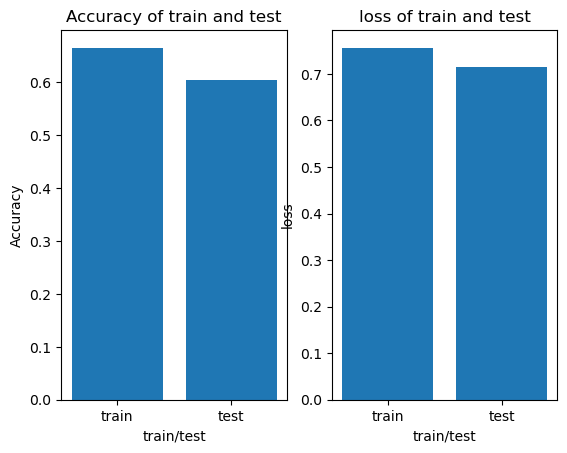

In [14]:
train_loss_vgg16, train_AUC_vgg16 = VGG16.evaluate(x_train_reshaped, y_train_tensor, verbose=0)
test_loss_vgg16, test_accuracy_vgg16 = VGG16.evaluate(x_test_reshaped, y_test_tensor, verbose=0)
print('Training AUC:', train_AUC_vgg16,"Train loss",train_loss_vgg16)
print('Testing AUC:', test_accuracy_vgg16,"Test Loss",test_loss_vgg16)
plt.subplot(1,2,1)
plt.bar(['train','test'], [train_AUC_vgg16,test_accuracy_vgg16])
plt.xlabel("train/test")
plt.ylabel("Accuracy")
plt.title("Accuracy of train and test")
plt.subplot(1,2,2)
plt.bar(['train','test'], [train_loss_vgg16,test_loss_vgg16])
plt.xlabel("train/test")
plt.ylabel("loss")
plt.title("loss of train and test")

result analysis:Apparently,train sets have higher accuracy and lower loss than test sets

Predictions

In [15]:
predictions_vgg16 = VGG16.predict(x_test_reshaped)
y_pred_vgg16 = (predictions_vgg16 > 0.5)

8/8 [==============================] - 17s 2s/step


Confusion Matrix and visualization

In [16]:
matrix = metrics.confusion_matrix(y_test_tensor, y_pred_vgg16)
matrix

array([[164,  12],
       [ 43,  15]], dtype=int64)

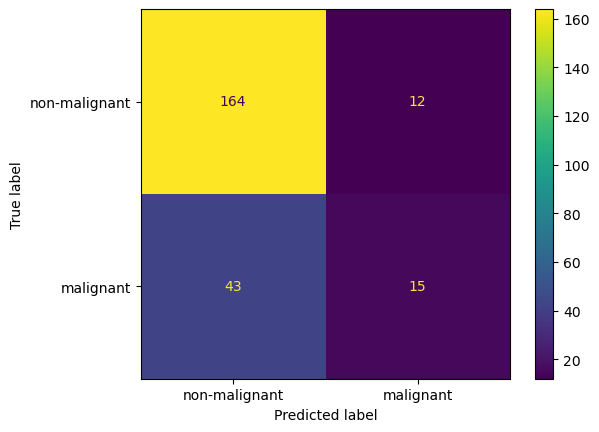

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
mono_disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["non-malignant","malignant"])
mono_disp.plot()

result analysis:from this chart,the model performs not good in malignant sets

False Pos/True Pos - ROC Curve

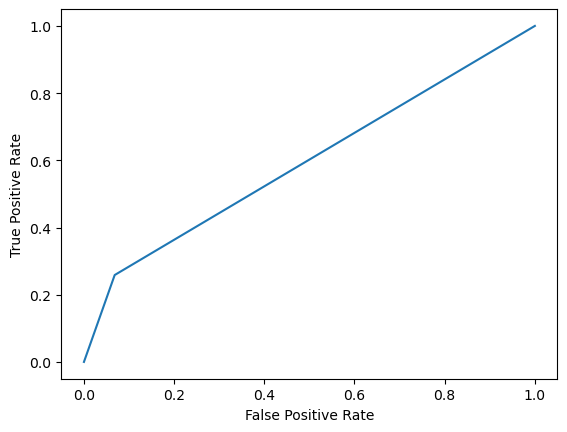

In [18]:
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_vgg16)

plt.plot(fpr1,tpr1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4>ResNet50</h4>

In [19]:

base     = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

ResNet50 = Sequential()

ResNet50.add(base)
ResNet50.add(MaxPooling2D((2, 2),1))
ResNet50.add(Dense(1024, activation='sigmoid'))
ResNet50.add(BatchNormalization())
ResNet50.add(MaxPooling2D((2, 2),1))
ResNet50.add(Dense(520, activation='sigmoid'))
ResNet50.add(Flatten())
ResNet50.add(Dense(1, activation='sigmoid'))

Compilation and Fitting

In [20]:
ResNet50.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

ResNet50.fit(x_train_reshaped, y_train_tensor, batch_size=32, epochs=20 ,validation_split=0.1)

Epoch 1/20
16/16 [==============================] - 69s 3s/step - loss: 0.5256 - auc_1: 0.8140 - val_loss: 0.6218 - val_auc_1: 0.5000
Epoch 2/20
16/16 [==============================] - 54s 3s/step - loss: 0.2730 - auc_1: 0.9298 - val_loss: 1.1829 - val_auc_1: 0.5000
Epoch 3/20
16/16 [==============================] - 53s 3s/step - loss: 0.1965 - auc_1: 0.9645 - val_loss: 0.9582 - val_auc_1: 0.4412
Epoch 4/20
16/16 [==============================] - 58s 4s/step - loss: 0.1664 - auc_1: 0.9771 - val_loss: 0.6580 - val_auc_1: 0.5944
Epoch 5/20
16/16 [==============================] - 54s 3s/step - loss: 0.1006 - auc_1: 0.9913 - val_loss: 0.6422 - val_auc_1: 0.2438
Epoch 6/20
16/16 [==============================] - 54s 3s/step - loss: 0.0408 - auc_1: 0.9946 - val_loss: 0.9375 - val_auc_1: 0.4605
Epoch 7/20
16/16 [==============================] - 54s 3s/step - loss: 0.0363 - auc_1: 0.9991 - val_loss: 1.4071 - val_auc_1: 0.5000
Epoch 8/20
16/16 [==============================] - 58s 4s/ste

AUC and Loss and visualization

Training AUC: 0.5 Train loss 1.6219614744186401
Testing AUC: 0.5 Test Loss 1.444936990737915


Text(0, 0.5, 'loss')

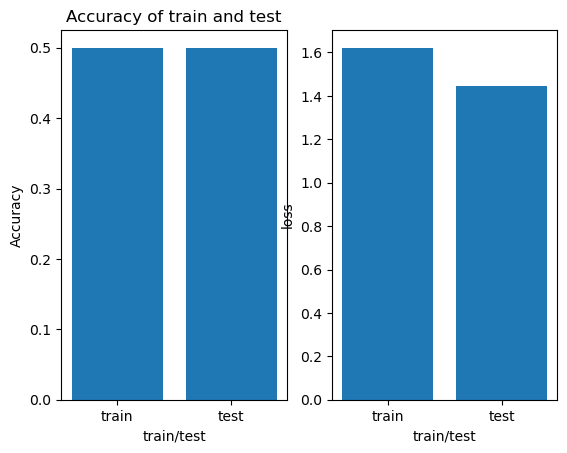

In [39]:
train_loss_ResNet50, train_AUC_ResNet50 = ResNet50.evaluate(x_train_reshaped, y_train_tensor, verbose=0)
test_loss_ResNet50, test_accuracy_ResNet50 = ResNet50.evaluate(x_test_reshaped, y_test_tensor, verbose=0)

print('Training AUC:', train_AUC_ResNet50,"Train loss",train_loss_ResNet50)
print('Testing AUC:', test_accuracy_ResNet50,"Test Loss",test_loss_ResNet50)
plt.subplot(1,2,1)
plt.bar(['train','test'], [train_AUC_ResNet50,test_accuracy_ResNet50])
plt.xlabel("train/test")
plt.ylabel("Accuracy")
plt.title("Accuracy of train and test")
plt.subplot(1,2,2)
plt.bar(['train','test'], [train_loss_ResNet50,test_loss_ResNet50])
plt.xlabel("train/test")
plt.ylabel("loss")

Predictions

In [22]:
predictions_ResNet50 = ResNet50.predict(x_test_reshaped)
y_pred_ResNet50= (predictions_ResNet50 > 0)

8/8 [==============================] - 6s 644ms/step


Confusion Matrix and visualization

In [23]:
matrix = metrics.confusion_matrix(y_test_tensor, y_pred_ResNet50)
matrix

array([[  0, 176],
       [  0,  58]], dtype=int64)

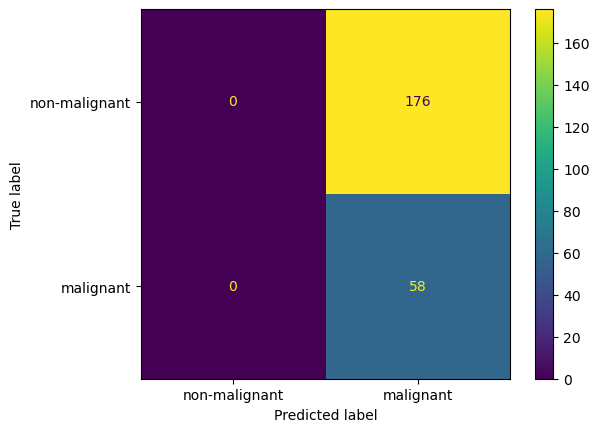

In [24]:
mono_disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["non-malignant","malignant"])
mono_disp.plot()

result analysis:from this chart,the model performs bad in non-malignant sets but performs good in malignant sets

False Pos/True Pos - ROC Curve

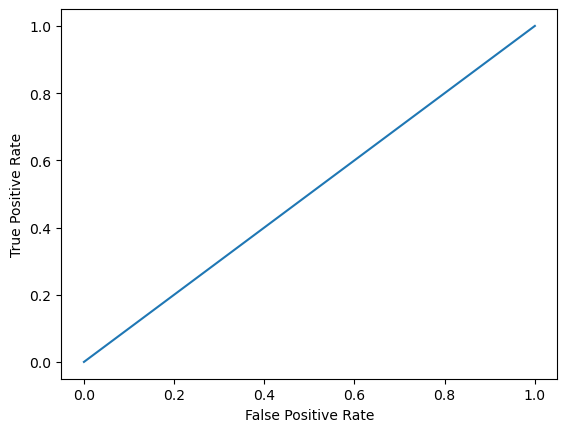

In [25]:
fpr2, tpr2, _ = metrics.roc_curve(y_test,  y_pred_ResNet50)

plt.plot(fpr2,tpr2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<h4>AlexNet</h4>

In [26]:

# create the model
AlexNet = Sequential()

# resize data to ImageNet size
AlexNet.add(experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train_reshaped.shape[1:]))

# convolution 1 - 96 filters with kernel 11x11 and stride of 4 (ReLU activation) - response normalisation
AlexNet.add(Conv2D(96, 11, strides=4, padding="same"))
AlexNet.add(Lambda(tf.nn.local_response_normalization))
AlexNet.add(Activation('relu'))
# pool with 3x3 kernel stride 2
AlexNet.add(MaxPooling2D(3, strides=2))

# convolution two - 256 layers with kernel 5x5 and stride of 4 (ReLU activation) - response normalisation
AlexNet.add(Conv2D(256, 5, strides=4, padding='same'))
AlexNet.add(Lambda(tf.nn.local_response_normalization))
AlexNet.add(Activation('relu'))
# pool with 3x3 kernel and stride 2
AlexNet.add(MaxPooling2D(3, strides=2))

# convolution 3 - 384 layers with kernel 3x3 and stride of 4 (ReLU Activation) - No Pool
AlexNet.add(Conv2D(384, 3, strides=4, padding='same'))
AlexNet.add(Activation('relu'))
# convolution 4 - 384 layers with kernel 3x3 and stride of 4 (ReLU Activation) - No Pool
AlexNet.add(Conv2D(384, 3, strides=4, padding='same'))
AlexNet.add(Activation('relu'))
# convolution 5 - 256 layers with kernel 3x3 and stride of 4 (ReLU Activation) - No Pool
AlexNet.add(Conv2D(256, 3, strides=4, padding='same'))
AlexNet.add(Activation('relu'))

# flatten for input into fully connected layers
AlexNet.add(Flatten())

# Fully connected 1 - 4096 hidden nodes - ReLU activation
AlexNet.add(Dense(4096, activation="relu"))
# Dropout 1 - rate 0.5
AlexNet.add(Dropout(0.5))

# Fully connected 2 - 4096 hidden nodes - ReLU activation
AlexNet.add(Dense(4096, activation="relu"))
# Dropout 2 - rate 0.5
AlexNet.add(Dropout(0.5))

# Fully Connected 3 - 1 output nodes - sigmoid activation
# Note - AlexNet usually classifies outside of binary and uses softmax
# sigmoid is used here instead to better suit our binary classification
AlexNet.add(Dense(1, activation="sigmoid"))

Compilation and Fitting

In [27]:
AlexNet.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

AlexNet.fit(x_train_reshaped, y_train_tensor, batch_size=32, epochs=20 ,validation_split=0.1)

Epoch 1/20
16/16 [==============================] - 8s 450ms/step - loss: 0.6212 - auc_2: 0.5136 - val_loss: 0.6180 - val_auc_2: 0.6099
Epoch 2/20
16/16 [==============================] - 8s 486ms/step - loss: 0.5879 - auc_2: 0.5484 - val_loss: 0.6584 - val_auc_2: 0.6176
Epoch 3/20
16/16 [==============================] - 8s 514ms/step - loss: 0.5954 - auc_2: 0.5076 - val_loss: 0.6183 - val_auc_2: 0.5000
Epoch 4/20
16/16 [==============================] - 7s 446ms/step - loss: 0.5935 - auc_2: 0.4494 - val_loss: 0.6192 - val_auc_2: 0.5000
Epoch 5/20
16/16 [==============================] - 7s 426ms/step - loss: 0.5895 - auc_2: 0.4822 - val_loss: 0.6209 - val_auc_2: 0.5000
Epoch 6/20
16/16 [==============================] - 7s 437ms/step - loss: 0.5905 - auc_2: 0.4831 - val_loss: 0.6236 - val_auc_2: 0.8460
Epoch 7/20
16/16 [==============================] - 8s 500ms/step - loss: 0.5868 - auc_2: 0.5371 - val_loss: 0.6131 - val_auc_2: 0.8762
Epoch 8/20
16/16 [==============================

AUC and Loss and visualization

AlexNet Training AUC: 0.9473267793655396 AlexNet Train loss 0.2684471011161804
AlexNet Testing AUC: 0.7799764275550842 AlexNet Test Loss 0.8367632627487183


Text(0, 0.5, 'loss')

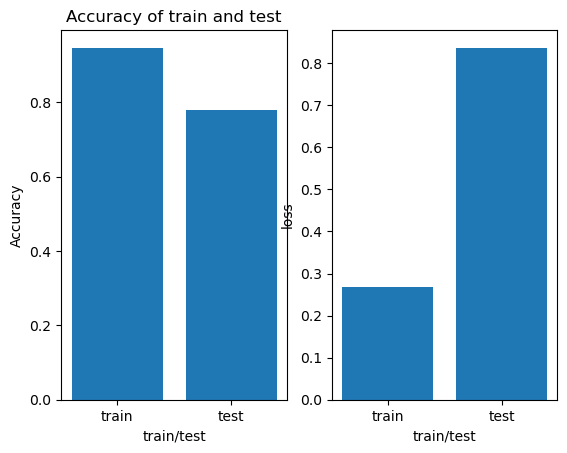

In [28]:
train_loss_alex, train_AUC_alex = AlexNet.evaluate(x_train_reshaped, y_train_tensor, verbose=0)
test_loss_alex, test_accuracy_alex = AlexNet.evaluate(x_test_reshaped, y_test_tensor, verbose=0)

print('AlexNet Training AUC:', train_AUC_alex,"AlexNet Train loss",train_loss_alex)
print('AlexNet Testing AUC:', test_accuracy_alex,"AlexNet Test Loss",test_loss_alex)
plt.subplot(1,2,1)
plt.bar(['train','test'], [train_AUC_alex,test_accuracy_alex])
plt.xlabel("train/test")
plt.ylabel("Accuracy")
plt.title("Accuracy of train and test")
plt.subplot(1,2,2)
plt.bar(['train','test'], [train_loss_alex,test_loss_alex])
plt.xlabel("train/test")
plt.ylabel("loss")

Predictions

In [29]:
predictions_alex = AlexNet.predict(x_test_reshaped)
predictions_alex = predictions_alex > 0.4

8/8 [==============================] - 1s 70ms/step


Confusion Matrix and visualization

In [30]:
matrix_alex = metrics.confusion_matrix(y_test_tensor, predictions_alex)
matrix_alex

array([[164,  12],
       [ 31,  27]], dtype=int64)

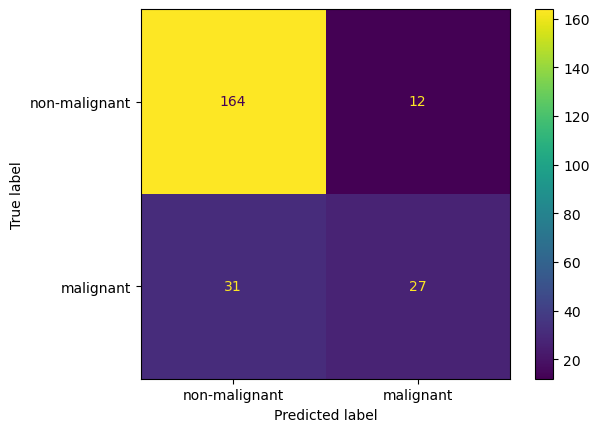

In [31]:
mono_disp = ConfusionMatrixDisplay(confusion_matrix=matrix_alex, display_labels=["non-malignant","malignant"])
mono_disp.plot()

result analysis:from this chart,the model performs good in non-malignant sets and performs common in malignant sets

False Pos/True Pos - ROC Curve

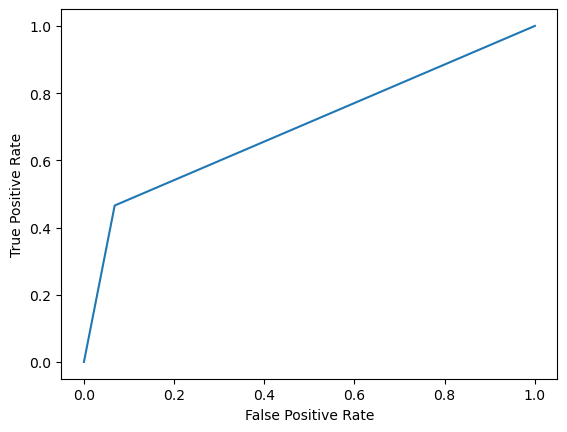

In [32]:
fpr_alex, tpr_alex, _ = metrics.roc_curve(y_test,  predictions_alex)
 
plt.plot(fpr_alex,tpr_alex)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

InceptionV3

In [33]:

## Inception A Block ##
def incA(prev, filters):
    #incA_input = Input(shape=(35, 35, 288))

    incA_1     = Conv2D(64, 1, activation="relu", padding="same")(prev)
    incA_1     = Conv2D(96, 3, activation="relu", padding="same")(incA_1)
    incA_1     = Conv2D(96, 3, activation="relu", padding="same" )(incA_1)

    incA_2     = Conv2D(48, 1, activation="relu", padding="same")(prev)
    incA_2     = Conv2D(64, 3, activation="relu", padding="same")(incA_2)

    incA_3     = AveragePooling2D(3, 1, padding="same")(prev)
    incA_3     = Conv2D(filters, 1, activation="relu", padding="same")(incA_3)

    incA_4     = Conv2D(64, 1, activation="relu", padding="same")(prev)

    incA       = Concatenate(axis=3)([incA_1, incA_2, incA_3, incA_4])

    return incA

    #incA       = Model(incA_input, incA)

# print(incA.shape)

## Inception B Block ##
def incB(prev, filters):
    # incB_input = Input(shape=(17, 17, 714))

    incB_1     = Conv2D(filters, 1, activation="relu", padding="same")(prev)
    incB_1     = Conv2D(filters, (7,1), activation="relu", padding="same")(incB_1)
    incB_1     = Conv2D(filters, (1,7), activation="relu", padding="same")(incB_1)
    incB_1     = Conv2D(filters, (7,1), activation="relu", padding="same")(incB_1)
    incB_1     = Conv2D(192, (1,7), activation="relu", padding="same")(incB_1)

    incB_2     = Conv2D(filters, 1, activation="relu", padding="same")(prev)
    incB_2     = Conv2D(filters, (1,7), activation="relu", padding="same")(incB_2)
    incB_2     = Conv2D(192, (7,1), activation="relu", padding="same")(incB_2)

    incB_3     = AveragePooling2D(3, 1, padding="same")(prev)
    incB_3     = Conv2D(192, 1, activation="relu", padding="same")(incB_3)

    incB_4     = Conv2D(192, 1, activation="relu", padding="same")(prev)

    incB       = Concatenate(axis=3)([incB_1, incB_2, incB_3, incB_4])

    return incB

    # incB       = Model(incB_input, incB)

# print(incB.shape)

# ## Inception C Block ##
def incC(prev):
    # incC_input = Input(shape=(8, 8, 1280))

    incC_1     = Conv2D(448, 1, activation="relu", padding="same")(prev)
    incC_1     = Conv2D(384, 3, activation="relu", padding="same")(incC_1)
    incC_1_a   = Conv2D(384, (1,3), activation="relu", padding="same")(incC_1)
    incC_1_b   = Conv2D(384, (3,1), activation="relu", padding="same")(incC_1)
    incC_1     = Concatenate(axis=3)([incC_1_a, incC_1_b])

    incC_2     = Conv2D(384, 1, activation="relu", padding="same")(prev)
    incC_2_a   = Conv2D(384, (1,3), activation="relu", padding="same")(incC_2)
    incC_2_b   = Conv2D(384, (3,1), activation="relu", padding="same")(incC_2)
    incC_2     = Concatenate(axis=3)([incC_2_a, incC_2_b])

    incC_3     = AveragePooling2D(3, 1, padding="same")(prev)
    incC_3     = Conv2D(192, 1, activation="relu", padding="same")(incC_3)

    incC_4     = Conv2D(320, 1, activation="relu", padding="same")(prev)

    incC       = Concatenate(axis=3)([incC_1, incC_2, incC_3, incC_4])

    return incC

    # incC       = Model(incC_input, incC)

# print(incC.shape)

# ## Reduction A Block ##
def redA(prev):
    # redA_input = Input(shape=(35, 35, 234))

    redA_1     = Conv2D(64, 1, activation="relu")(prev)
    redA_1     = Conv2D(96, 3, activation="relu")(redA_1)
    redA_1     = Conv2D(96, 3, activation="relu", padding="same", strides=(2,2))(redA_1)

    redA_2     = Conv2D(384,  3, activation="relu", padding="valid", strides=(2,2))(prev)

    redA_3     = MaxPooling2D(3, 2, padding="valid")(prev)

    redA       = Concatenate(axis=3)([redA_1, redA_2, redA_3])

    return redA

    # redA       = Model(redA_input, redA)

# print(redA.shape)

# ## Reduction B Block ##
def redB(prev):
    # redB_input = Input(shape=(17, 17, 768))

    redB_1     = Conv2D(192, 1, activation="relu", padding="same")(prev)
    redB_1     = Conv2D(192, (1,7), activation="relu", padding="same")(redB_1)
    redB_1     = Conv2D(192, (7,1), activation="relu", padding="same")(redB_1)
    redB_1     = Conv2D(192, 3, activation="relu", strides=(2,2), padding="valid")(redB_1)

    redB_2     = Conv2D(192, 1, activation="relu")(prev)
    redB_2     = Conv2D(320, 3, activation="relu", strides=(2,2), padding="valid")(redB_2)

    redB_3     = MaxPooling2D(3, 2, padding="valid")(prev)

    redB       = Concatenate(axis=3)([redB_1, redB_2, redB_3])

    return redB

    # redB       = Model(redB_input, redB)

# print(redB.shape)

## Main Inception v3 model ##

# take in input image
input       = Input(shape=(150,150,3))
# resize
resized     = experimental.preprocessing.Resizing(299, 299, interpolation="bilinear", input_shape=x_train_reshaped.shape[1:])(input)
# convolution 1 - 3x3 kernel - stride 2 - 32 layers
lay1        = Conv2D(32 , 3, strides=2, activation="relu")(resized)
# convolution 2 - 3x3 kernel - stride 1 - 32 layers
lay2        = Conv2D(32, 3, activation="relu")(lay1)
# convolution 3 - 3x3 kernel - stride 1 - 64 layers - padded
lay3        = Conv2D(64, 3, activation="relu")(lay2)
# pooling 1 - 3x3 kernel - stride 2
lay4        = MaxPooling2D(3, 2)(lay3)
# convolution 4 - 3x3 kernel - stride 1 - 80 layers
lay5        = Conv2D(80, 1, activation="relu")(lay4)
# convolution 5 - 3x3 kernel - stride 2 - 192 layers
lay6        = Conv2D(192, 3, activation="relu")(lay5)
# convolution 6 - 3x3 kernel - stride 1 - 288 layers
lay7        = MaxPooling2D(3, 2)(lay6)

# inception A model
lay8        = incA(lay7, 32)
# incpetion A model
lay9        = incA(lay8, 64)
# inception A model
lay10       = incA(lay9, 64)

# reduction A model
lay11       = redA(lay10)

# inception B model
lay12       = incB(lay11, 128)
# incpetion B model
lay13       = incB(lay12, 160)
# inception B model
lay14       = incB(lay13, 160)
# inception B model
lay15       = incB(lay14, 192)

# reduction B model
lay16       = redB(lay15)

# inception C model
lay17       = incC(lay16)
# inception C model
lay18       = incC(lay17)

# global average pooling for flattening
lay19       = GlobalAveragePooling2D()(lay18)

# fully connected layer 2048 hidden units - ReLU activation
lay20       = Dense(2048, activation="relu")(lay19)

# dropout layer - rate 0.2
lay21       = Dropout(rate=0.2)(lay20)

# Output fully connected - 1 output - sigmoid activation
output      = Dense(1, activation="sigmoid")(lay20)

InceptionV3   = Model(inputs=input, outputs=output)

In [34]:
InceptionV3.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc")])

InceptionV3.fit(x_train_reshaped, y_train_tensor, batch_size=32, epochs=20 ,validation_split=0.1)

Epoch 1/20
16/16 [==============================] - 104s 6s/step - loss: 0.7133 - auc: 0.5046 - val_loss: 0.6458 - val_auc: 0.5000
Epoch 2/20
16/16 [==============================] - 88s 6s/step - loss: 0.6212 - auc: 0.5030 - val_loss: 0.6194 - val_auc: 0.5000
Epoch 3/20
16/16 [==============================] - 87s 5s/step - loss: 0.5885 - auc: 0.5300 - val_loss: 0.6417 - val_auc: 0.5000
Epoch 4/20
16/16 [==============================] - 140s 9s/step - loss: 0.5935 - auc: 0.5172 - val_loss: 0.6197 - val_auc: 0.5000
Epoch 5/20
16/16 [==============================] - 89s 5s/step - loss: 0.5936 - auc: 0.4370 - val_loss: 0.6198 - val_auc: 0.5000
Epoch 6/20
16/16 [==============================] - 82s 5s/step - loss: 0.5895 - auc: 0.4466 - val_loss: 0.6195 - val_auc: 0.5000
Epoch 7/20
16/16 [==============================] - 84s 5s/step - loss: 0.5900 - auc: 0.4416 - val_loss: 0.6197 - val_auc: 0.5000
Epoch 8/20
16/16 [==============================] - 83s 5s/step - loss: 0.5891 - auc: 0.

AUC and Loss and visualization

Inception Training AUC: 0.5 Inception Train loss 0.591833233833313
Inception Testing AUC: 0.5 Inception Test Loss 0.5646970868110657


Text(0, 0.5, 'loss')

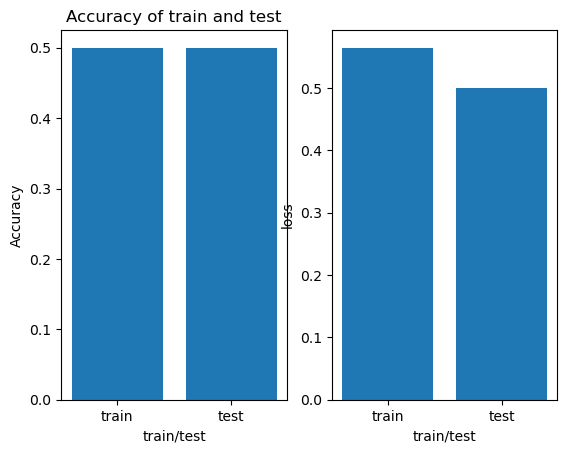

In [35]:
train_loss_incep, train_AUC_incep = InceptionV3.evaluate(x_train_reshaped, y_train_tensor, verbose=0)
test_loss_incep, test_accuracy_incep = InceptionV3.evaluate(x_test_reshaped, y_test_tensor, verbose=0)

print('Inception Training AUC:', train_AUC_incep,"Inception Train loss",train_loss_incep)
print('Inception Testing AUC:', test_accuracy_incep,"Inception Test Loss",test_loss_incep)
plt.subplot(1,2,1)
plt.bar(['train','test'], [train_AUC_incep,test_accuracy_incep])
plt.xlabel("train/test")
plt.ylabel("Accuracy")
plt.title("Accuracy of train and test")
plt.subplot(1,2,2)
plt.bar(['train','test'], [test_loss_incep,test_accuracy_incep])
plt.xlabel("train/test")
plt.ylabel("loss")

Predictions

In [36]:
predictions_inc = InceptionV3.predict(x_test_reshaped)
predictions_inc = predictions_inc > 0.3

8/8 [==============================] - 10s 1s/step


Confusion Matrix and visualization

In [37]:
matrix_inc = metrics.confusion_matrix(y_test_tensor, predictions_inc)
matrix_inc

array([[176,   0],
       [ 58,   0]], dtype=int64)

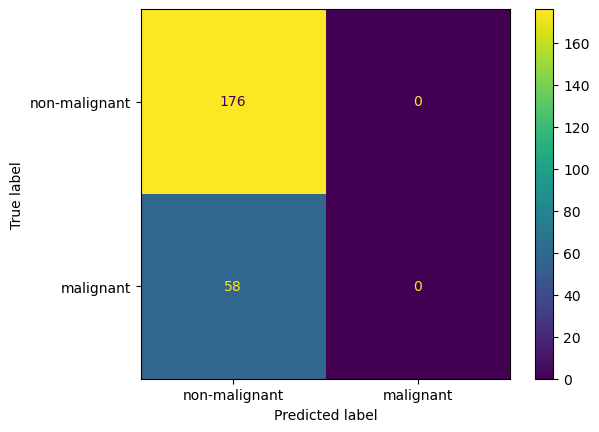

In [40]:
mono_disp = ConfusionMatrixDisplay(confusion_matrix=matrix_inc, display_labels=["non-malignant","malignant"])
mono_disp.plot()

result analysis:from this chart,the model performs good in non-malignant sets and performs bad in malignant sets

False Pos/True Pos - ROC Curve

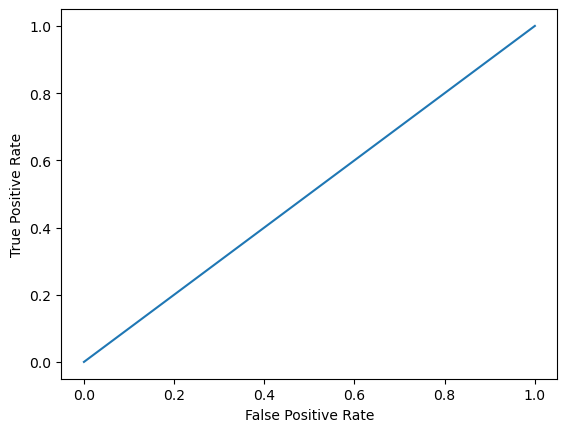

In [38]:
fpr_inc, tpr_inc, _ = metrics.roc_curve(y_test,  predictions_inc)
 
plt.plot(fpr_inc,tpr_inc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

comparison among four methods by visualization

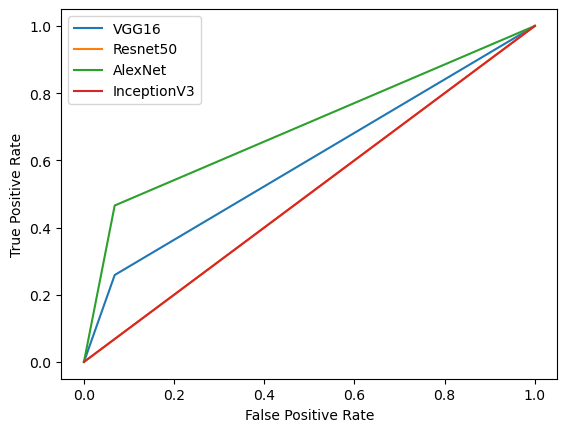

In [44]:
plt.plot(fpr1,tpr1,label='VGG16')
plt.plot(fpr2,tpr2,label='Resnet50')
plt.plot(fpr_alex,tpr_alex,label='AlexNet')
plt.plot(fpr_inc,tpr_inc,label='InceptionV3')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


result analysis:as we see,the AlexNet has the best performance,followed by the VGG16.The InceptionV3 and Resnet50 are the worst two models with the same performance.

Discussion: In the whole project,we totally have four models including VGG16,ResNet50,AlexNet,InceptionV3. The performance ranking is AlexNet>VGG16>ResNet50=InceptionV3.Hence,the strength we have should be AlexNet with accuracy of almost 80 percent and VGG16 with accuracy of 
almost 70 percent,instead,the weakness should be the ResNet50 and inception. For limitation,due to long training time,our system is not much suitable for images with big image size,hence,we have to resize the images,which possibly affect the precision. 

In the future,we need to focus on the reinforcement of InceptionV3 and ResNet50 by several methods,such as hyperparameter tuning algorithm to find the best hyperparameter combination. Also,we need to solve the class imbalance problem which probably affected the performance of our system,even the best model.At last,we have to improve the models for processing the images with big size.